## ready_array2.npz as dataset

In [1]:
import numpy as np
import random
import pandas as pd
import h5py

In [2]:
cholesterol = 'C:/Users/CCheny/Documents/UC San Diego - Junction/Bioinformatics/MS2-Autoencoder/Output/cholesterol/ready_array2.npz'
cortisol = 'C:/Users/CCheny/Documents/UC San Diego - Junction/Bioinformatics/MS2-Autoencoder/Output/cortisol/ready_array2.npz'

In [3]:
file1 = np.load(cholesterol, allow_pickle=True)
file2 = np.load(cortisol, allow_pickle=True)
data1 = file1['arr_0']
data2 = file2['arr_0']

In [4]:
data = np.concatenate((data1, data2), axis=0)
type(data.shape)

tuple

### hdf5

In [5]:
file = 'C:/Users/CCheny/Documents/UC San Diego - Junction/Bioinformatics/MS2-Autoencoder/chemical_split_data.hdf5'

In [6]:
f = h5py.File(file, 'r')

In [7]:
dataset_low = f['low_peaks']
dataset_high = f['high_peaks']
print(dataset_low.shape)
print(dataset_high.shape)

(110881, 1, 2000)
(110881, 1, 2000)


## processing

In [8]:
#random.shuffle(data)
new_list = np.split(data, 2, axis=1)

In [9]:
low_peaks = new_list[0]
low_peaks = low_peaks.astype('float32')
print(low_peaks.shape)
high_peaks = new_list[1]
high_peaks = high_peaks.astype('float32')
print(high_peaks.shape)

(10130, 1, 2000)
(10130, 1, 2000)


In [7]:
size = low_peaks.shape

In [55]:
with h5py.File('training_data.hdf5', 'w') as f:
    dataset = f.create_dataset('low_peaks', data=low_peaks, shape=low_peaks.shape, dtype='f4')
    dataset = f.create_dataset('high_peaks', data=high_peaks, shape=high_peaks.shape, dtype='f4')
    print(f.keys())

<KeysViewHDF5 ['high_peaks', 'low_peaks']>


In [48]:
with h5py.File('training_data.hdf5', 'r') as f:
    low_peaks = f['low_peaks']
    print(low_peaks.len())
    high_peaks = f['high_peaks']

10130


In [8]:
def normalize_peaks(peaks_array):
    for i in range(0, len(peaks_array)):
        peak_max = np.amax(peaks_array[i])
        if peak_max==0.0:
            peaks_array[i] = peaks_array[i]
        else:
            peaks_array[i] = peaks_array[i] / peak_max
    return peaks_array

In [31]:
def normalize_peaks2(peaks_array):
    from sklearn.preprocessing import normalize
    
    for i in range(0, len(peaks_array)):
        peaks_array[i] = normalize(peaks_array[i], norm='l1')
    return peaks_array

In [32]:
low_peaks_norm = normalize_peaks2(low_peaks)
high_peaks_norm = normalize_peaks2(high_peaks)

## keras

In [33]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import regularizers

In [34]:
X = low_peaks_norm
y = high_peaks_norm

In [35]:
'''
Xcut = int(0.8*len(X))
X_train = X[:Xcut,:,:]
X_test = X[Xcut:,:,:]
print(X_train.shape)
print(X_test.shape)
X_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
X_test = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))
print(X_train.shape)
print(X_test.shape)

ycut = int(0.8*len(y))
y_train = y[:ycut,:,:]
y_test = y[ycut:,:,:]
print(y_train.shape)
print(y_test.shape)
y_train = y_train.reshape(len(y_train), np.prod(y_train.shape[1:]))
y_test = y_test.reshape(len(y_test), np.prod(y_test.shape[1:]))
print(y_train.shape)
print(y_test.shape)
'''

'\nXcut = int(0.8*len(X))\nX_train = X[:Xcut,:,:]\nX_test = X[Xcut:,:,:]\nprint(X_train.shape)\nprint(X_test.shape)\nX_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))\nX_test = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))\nprint(X_train.shape)\nprint(X_test.shape)\n\nycut = int(0.8*len(y))\ny_train = y[:ycut,:,:]\ny_test = y[ycut:,:,:]\nprint(y_train.shape)\nprint(y_test.shape)\ny_train = y_train.reshape(len(y_train), np.prod(y_train.shape[1:]))\ny_test = y_test.reshape(len(y_test), np.prod(y_test.shape[1:]))\nprint(y_train.shape)\nprint(y_test.shape)\n'

In [36]:
X_train = X[:,:,:]
print(X_train.shape)
X_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
print(X_train.shape)

y_train = y[:,:,:]
print(y_train.shape)
y_train = y_train.reshape(len(y_train), np.prod(y_train.shape[1:]))
print(y_train.shape)

(10130, 1, 2000)
(10130, 2000)
(10130, 1, 2000)
(10130, 2000)


In [37]:
input_size = 2000
encoding_dim = 100

input_scan = Input(shape=(input_size, ))
hidden_1 = Dense(1000, activation='relu')(input_scan) #encoded is the encoded representation of the input
hidden_2 = Dense(500, activation='relu')(hidden_1)
encoded = Dense(encoding_dim, activation='relu')(hidden_2)
hidden_3 = Dense(500, activation='relu')(encoded)
hidden_4 = Dense(1000, activation='relu')(hidden_3)
decoded = Dense(input_size, activation='relu')(hidden_4) #decoded is the reconstruction of the input

autoencoder = Model(input_scan, decoded) #this model maps an input to its reconstructions

In [38]:
autoencoder.compile(optimizer='adadelta', loss='cosine_proximity', metrics=['accuracy'])

In [39]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_8 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_9 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_10 (Dense)             (None, 500)               50500     
_________________________________________________________________
dense_11 (Dense)             (None, 1000)              501000    
_________________________________________________________________
dense_12 (Dense)             (None, 2000)              2002

In [40]:
from keras.callbacks import TensorBoard

autoencoder.fit(X_train, y_train, 
                epochs=50, 
                batch_size=100, 
                #validation_data=(X_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
10130/10130 [==============================] - 4s 393us/step - loss: -0.3483 - accuracy: 0.2220
Epoch 2/50
10130/10130 [==============================] - 4s 373us/step - loss: -0.5162 - accuracy: 0.3851
Epoch 3/50
10130/10130 [==============================] - ETA: 0s - loss: -0.5835 - accuracy: 0.467 - 4s 375us/step - loss: -0.5837 - accuracy: 0.4677
Epoch 4/50
10130/10130 [==============================] - 4s 375us/step - loss: -0.6183 - accuracy: 0.5044
Epoch 5/50
10130/10130 [==============================] - 4s 375us/step - loss: -0.6345 - accuracy: 0.5272
Epoch 6/50
10130/10130 [==============================] - 4s 380us/step - loss: -0.6447 - accuracy: 0.5375
Epoch 7/50
10130/10130 [==============================] - 4s 403us/step - loss: -0.6559 - accuracy: 0.5520
Epoch 8/50
10130/10130 [==============================] - ETA: 0s - loss: -0.6611 - accuracy: 0.557 - 4s 391us/step - loss: -0.6613 - accuracy: 0.5578
Epoch 9/50
10130/10130 [==============================] 

In [41]:
from scipy import spatial

sum = 0
for i in range(0, len(X_train)):
    if np.amax(X_train[i]) <= 0.0 or np.amax(y_train[i]) <= 0.0:
        continue
    else:
        dataSetI = X_train[i]
        dataSetII = y_train[i]
        result = 1 - spatial.distance.cosine(dataSetI, dataSetII)
        sum += result
print(sum / len(X_train))

0.5935094109513895


In [42]:
sum = 0
for i in range(0, len(X_test)):
    if np.amax(X_test[i]) <= 0.0 or np.amax(y_test[i]) <= 0.0:
        continue
    else:
        dataSetI = X_test[i]
        dataSetII = y_test[i]
        result = 1 - spatial.distance.cosine(dataSetI, dataSetII)
        sum += result
print(sum / len(X_test))

NameError: name 'X_test' is not defined

In [43]:
predicted = autoencoder.predict(X_train)

0.14968815
0.26108235
0.10708334


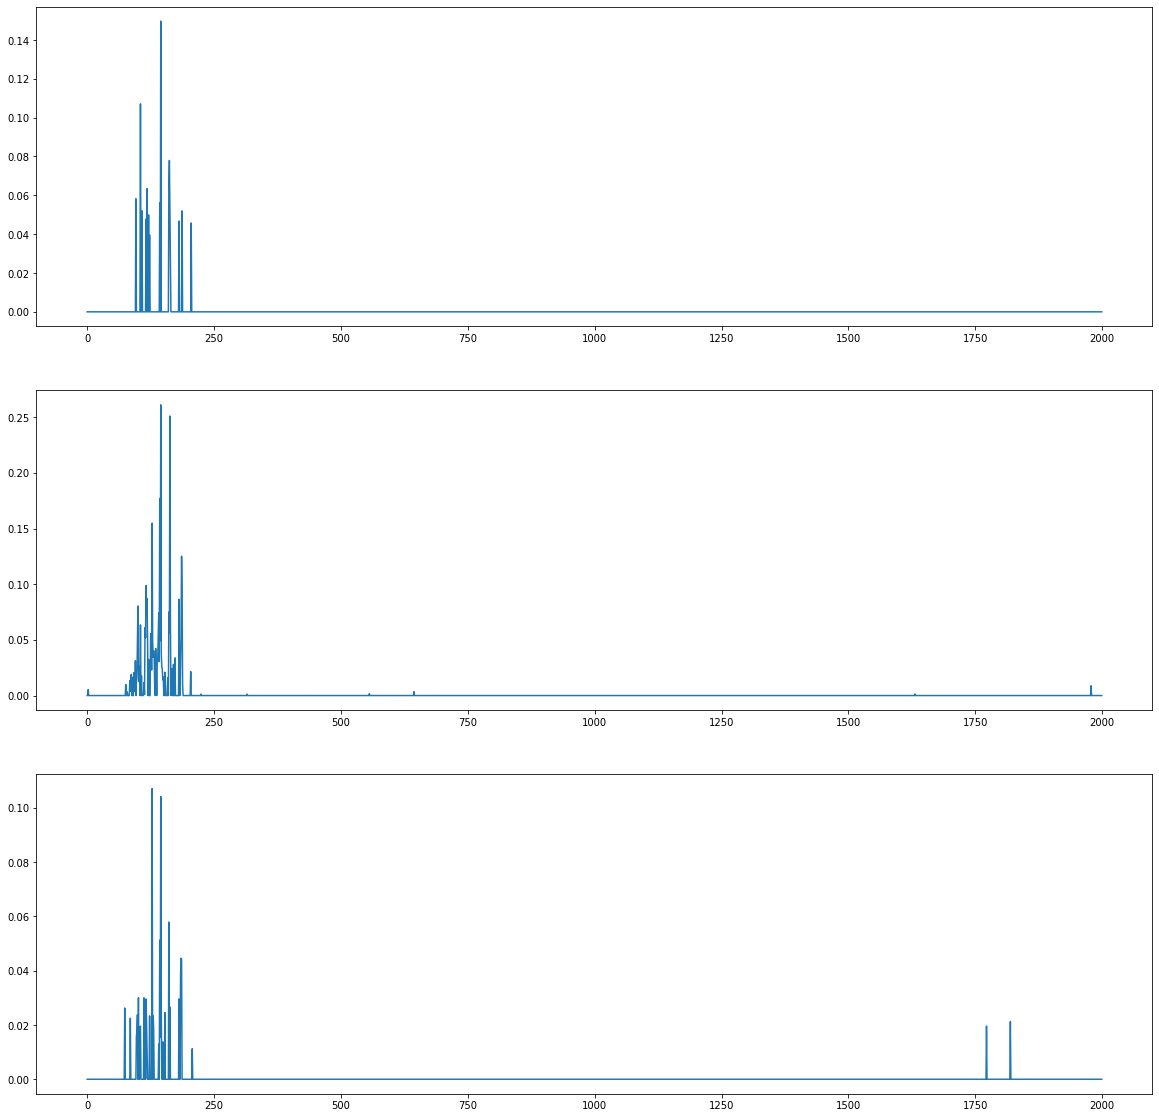

In [50]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(20,20))
i = 24
first = X_train[i]
second = predicted[i]
third = y_train[i]
top_max = predicted[i]

axs[0].plot(range(0, 2000), first)
#axs[0].set_ylim(bottom=0, top=np.amax(top_max), auto=True)
print(np.amax(first))

axs[1].plot(range(0, 2000), second)
#axs[1].set_ylim(bottom=0, top=np.amax(top_max), auto=True)
print(np.amax(second))

axs[2].plot(range(0, 2000), third)
#axs[2].set_ylim(bottom=0, top=np.amax(top_max), auto=True)
print(np.amax(third))